In [1]:
from imports import *
import pickle

# device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
device = torch.device("cuda:1")

In [2]:
classes = {
    "bus": 0,
    "traffic light": 1,
    "traffic sign": 2,
    "person": 3,
    "bike": 4,
    "truck": 5,
    "motor": 6,
    "car": 7,
    "train": 8,
    "rider": 9,
}
class_2_name = dict([(value, key) for key, value in classes.items()])

num_classes = len(classes)

In [3]:
with open('tst.txt','w') as f:
    f.writelines(', '.join(classes))

## 1. Load model

In [4]:
def get_model(num_classes):
    model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    #model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes) # replace the pre-trained head with a new one
    model.roi_heads.box_predictor = torchvision.models.detection.faster_rcnn.FastRCNNPredictor(in_features,num_classes)
    return model

In [5]:
model = get_model(num_classes)

In [6]:
checkpoint = torch.load('saved_models/bdd100k_24.pth')
model.load_state_dict(checkpoint['model'])
#optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
#epoch = checkpoint['epoch']
model.eval()
model.to(device)

FasterRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256)
          (relu): ReLU(inplace=True)
          (downsample)

In [38]:
from datasets.bdd_oia import BDD_OIA
image_dir = './data/bdd_oia/lastframe/data/'
label_dir = './data/bdd_oia/lastframe/labels/'

batch_size =5

val_bdd_oia_dataset = BDD_OIA(image_dir,label_dir+'val_25k_images_actions.json',
                             label_dir+'val_25k_images_reasons.json')

val_loader = DataLoader(val_bdd_oia_dataset,shuffle=False,batch_size=batch_size,collate_fn=utils.collate_fn)

2259 2259 2259
number of samples in dataset:2259


## 2. Show sample plot

In [39]:
def get_preds(idx,img_datalist,threshold):
    im0 = Image.open(img_datalist[idx])
    im0_tensor = torchvision.transforms.ToTensor()(im0)
    pred = model([im0_tensor.to(device)])
    total_preds = []
    for n,confidence in enumerate(pred[0]['scores']):
        if confidence>threshold:
            pred_update = {}
            pred_update['boxes'] = pred[0]['boxes'][n]
            pred_update['labels'] = pred[0]['labels'][n]
            pred_update['scores'] = pred[0]['scores'][n]
        total_preds.append(pred_update)
    return im0,total_preds


def get_preds_from_loader(images,threshold):
    
    im_list = list(image.to(device) for image in images)
    out_im_list = list(image.permute(1, 2, 0).numpy() for image in images)
    pred = model(im_list)
    total_preds = []
    for n,confidence in enumerate(pred[0]['scores']):
        if confidence>threshold:
            pred_update = {}
            pred_update['boxes'] = pred[0]['boxes'][n]
            pred_update['labels'] = pred[0]['labels'][n]
            pred_update['scores'] = pred[0]['scores'][n]
        total_preds.append(pred_update)
    return out_im_list,total_preds

In [40]:
def plot_from_image_preds(imgs,total_preds):
    fig,axes = plt.subplots(len(imgs),figsize=(10*len(imgs),10))
    for ind,img in enumerate(imgs):
        ax = axes[ind]
        for i in range(len(total_preds)):
            xy = total_preds[i]['boxes'][0],total_preds[i]['boxes'][1]
            width = total_preds[i]['boxes'][2]-total_preds[i]['boxes'][0]
            height = total_preds[i]['boxes'][3]-total_preds[i]['boxes'][1]
            rect = patches.Rectangle(xy,width,height,linewidth=1,edgecolor='r',facecolor='none')
            ax.text(xy[0],xy[1],class_2_name[total_preds[i]['labels'].item()])
            ax.add_patch(rect)
        ax.imshow(img)

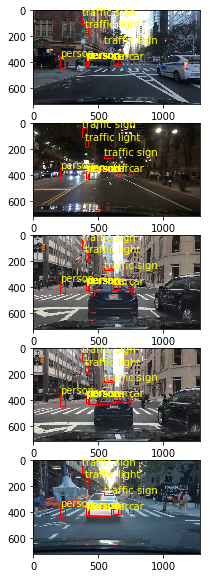

In [43]:
ims, total_preds = get_preds_from_loader(images,0.8)
plot_from_image_preds(ims,total_preds)

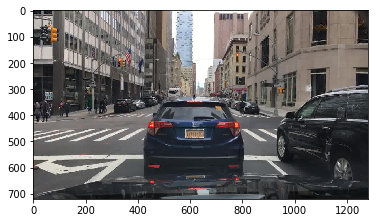

In [44]:
plt.imshow(ims[2])